In [1]:
import sys, os, pickle
import torch
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from LDR_dim import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
from functools import partial
import matplotlib.pyplot as plt

In [43]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 1
macro_configs = config_generator(I=[0.01, 0.03, 0.1, 0.3, 1, 3],
                                 C_scale=list(np.round(np.arange(0.5, 2.1, 0.1), 2)))

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [3]:
### --- Set empirical parameters --- ###

#network properties size
N = 2000
phi_torch = lambda x: torch.relu(x)
phi_prime_torch = lambda x: (x > 0).to(torch.float32)
g = 3
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

In [78]:
#iid network

if False:

    mu = params['mu']
    dt = 0.05
    W_ = torch.from_numpy(np.random.normal(mu/N, g/np.sqrt(N), (N, N))).type(torch.FloatTensor).to(0)
    x, r = sample_activity(T_sim=600, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                           runga_kutta=True, T_save_delay=200, input_current=params['I']*torch.ones(N)[None,:].to(0))

In [37]:
#low-rank network
sigma_diag = 1.6
sigma_off = 0.8
C_scale = params['C_scale']
#C_scale = 1
sigma_mn = C_scale*np.array([[sigma_diag, -sigma_off],
                                       [sigma_off, sigma_diag]])
sigma_mm = np.eye(2)
n_var = 10
sigma_nn = n_var * np.eye(2)

covariance_top = np.hstack([sigma_mm, sigma_mn])
covariance_bot = np.hstack([sigma_mn.T, sigma_nn])
covariance = np.vstack([covariance_top, covariance_bot])/N

#means = np.array([0, 0, params['mu'], params['mu']])/N
means = np.zeros(4)
loadings = np.random.multivariate_normal(means, covariance, size=N)

m1 = loadings[:,0]
m2 = loadings[:,1]
n1 = loadings[:,2]
n2 = loadings[:,3]
M = np.multiply.outer(m1, n1) + np.multiply.outer(m2, n2)

W_ = torch.from_numpy(M).type(torch.FloatTensor).to(0)
dt = 0.05
I = params['I']
#I = 0.3
x, r = sample_activity(T_sim=600, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=200, input_current=I*torch.ones(N)[None,:].to(0))

In [38]:
z = np.einsum('ti, ir -> tr', r, loadings)

In [40]:
processed_data = np.hstack([x[:5000,0][:,None], z[:5000]])

In [14]:
### --- SAVE RESULTS -- ###
result = {'sim': None, 'dim_emp': None,
          'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [44]:
###Truncate file above
file_name = 'relu_chaos'
job_name = 'I_C_3'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook relu_chaos.ipynb to script
[NbConvertApp] Writing 5546 bytes to relu_chaos.py
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b3727289c10> <built-in function print>
awk: cmd. line:1:                       ^ syntax error
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b3727289c10> <built-in function print>
awk: cmd. line:1:                                                                                ^ syntax error


In [45]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name), mem=64, n_hours=24, n_gpus=1,
               results_subdir='misc')
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
submit_job(job_script_path, n_jobs, execute=False,
           results_subdir='misc', lkumar=True)

rm: cannot remove ‘/home/om2382/low-rank-dims/results/misc/I_C_3/result_*’: No such file or directory
sending incremental file list
mft-theory/
mft-theory/.DS_Store
mft-theory/.gitignore
mft-theory/README.md
mft-theory/__init__.py
mft-theory/jupyter_notebook.py
mft-theory/main.ipynb
mft-theory/.idea/
mft-theory/.idea/mft-theory.iml
mft-theory/.idea/misc.xml
mft-theory/.idea/modules.xml
mft-theory/.idea/vanilla-rtrl.iml
mft-theory/.idea/vcs.xml
mft-theory/.idea/workspace.xml
mft-theory/.idea/codeStyles/
mft-theory/.idea/codeStyles/codeStyleConfig.xml
mft-theory/.ipynb_checkpoints/
mft-theory/.ipynb_checkpoints/main-checkpoint.ipynb
mft-theory/LDR_dim/
mft-theory/LDR_dim/__init__.py
mft-theory/LDR_dim/extensive_tasks.py
mft-theory/LDR_dim/solve_ldr.ipynb
mft-theory/LDR_dim/util.py
mft-theory/LDR_dim/LDR-dim/
mft-theory/LDR_dim/LDR-dim/__init__.py
mft-theory/LDR_dim/LDR-dim/solve_ldr.ipynb
mft-theory/LDR_dim/LDR-dim/util.py
mft-theory/cluster/
mft-theory/cluster/__init__.py
mft-theory/clu

In [53]:
###Get job status
get_ipython().system('squeue -u om2382')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           3796158    lkumar  jupyter   om2382  R    1:06:51      1 ax14


In [55]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'I_C_3'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
results = unpack_processed_data(job_script_path, results_subdir='misc')

In [56]:
results[0]

{'I': [0.01, 0.03, 0.1, 0.3, 1, 3],
 'C_scale': [0.5,
  0.6,
  0.7,
  0.8,
  0.9,
  1.0,
  1.1,
  1.2,
  1.3,
  1.4,
  1.5,
  1.6,
  1.7,
  1.8,
  1.9,
  2.0],
 'i_seed': [0]}

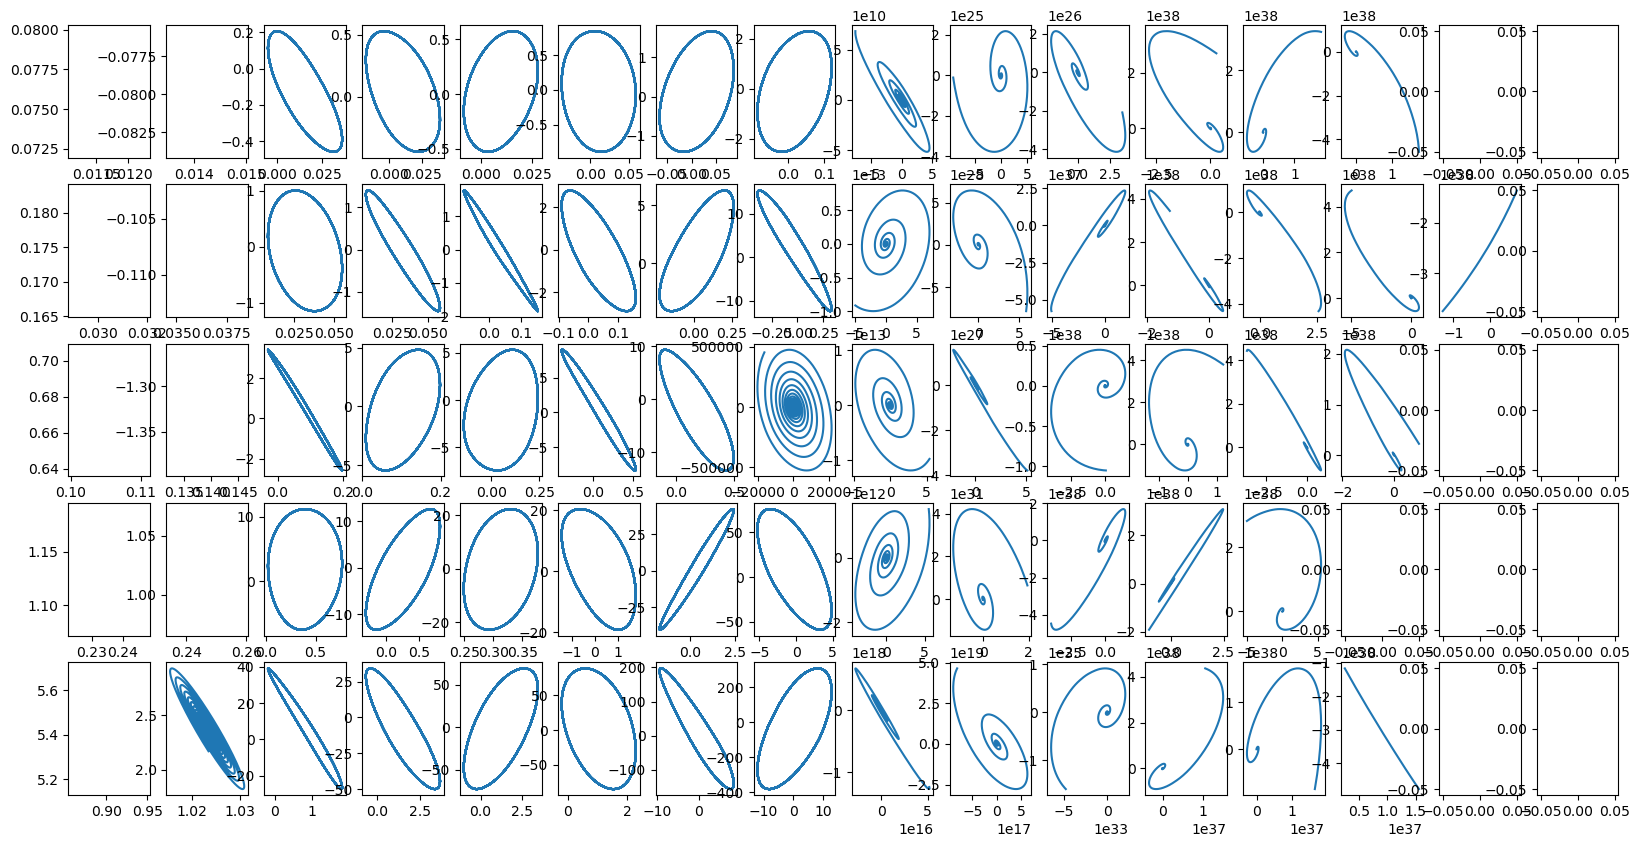

In [63]:
fig, ax = plt.subplots(5, 16, figsize=(20, 10))
for i in range(5):
    for j in range(16):
        #ax[i,j].plot(results[1][i,j,0,:,0])
        ax[i,j].plot(results[1][i,j,0,:,0], results[1][i,j,0,:,1])
        #ax[i,j].set_xticks([])
        #ax[i,j].set_yticks([])

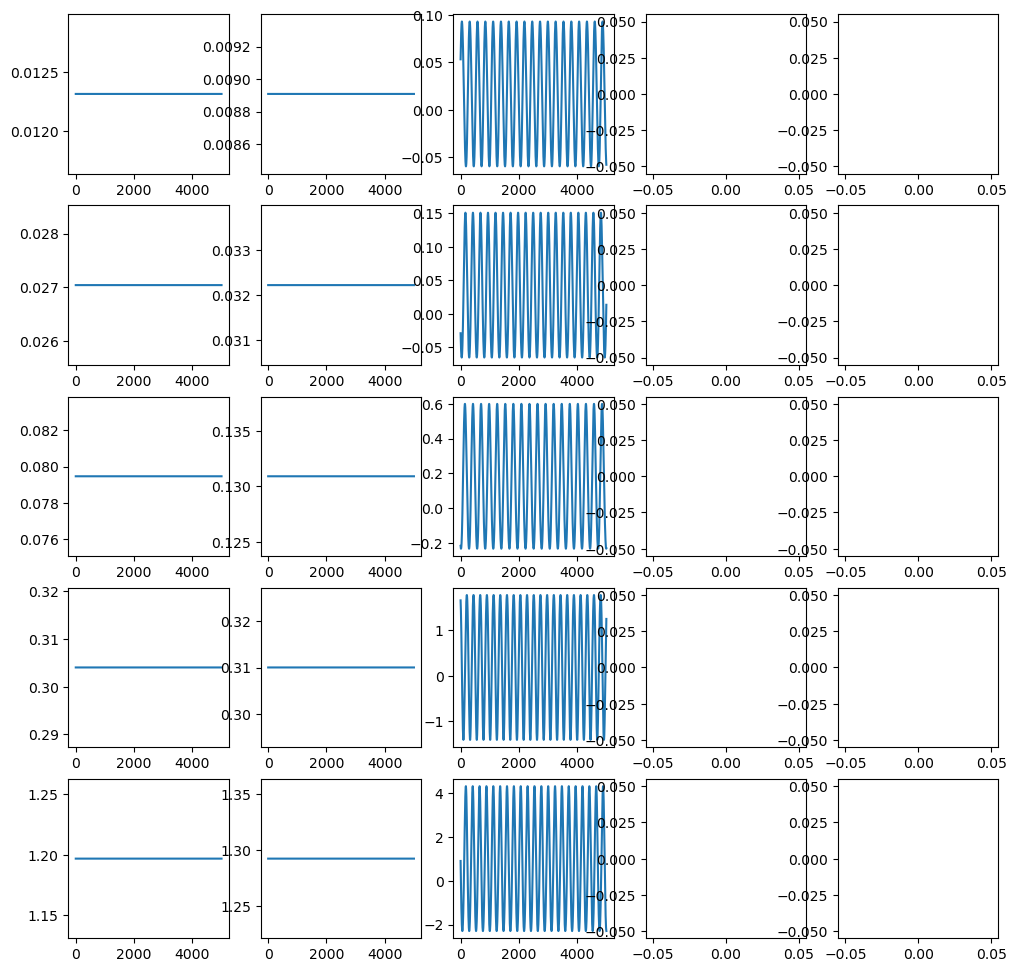

In [20]:
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
for i in range(5):
    for j in range(5):
        ax[i,j].plot(results[1][i,j,0,:])

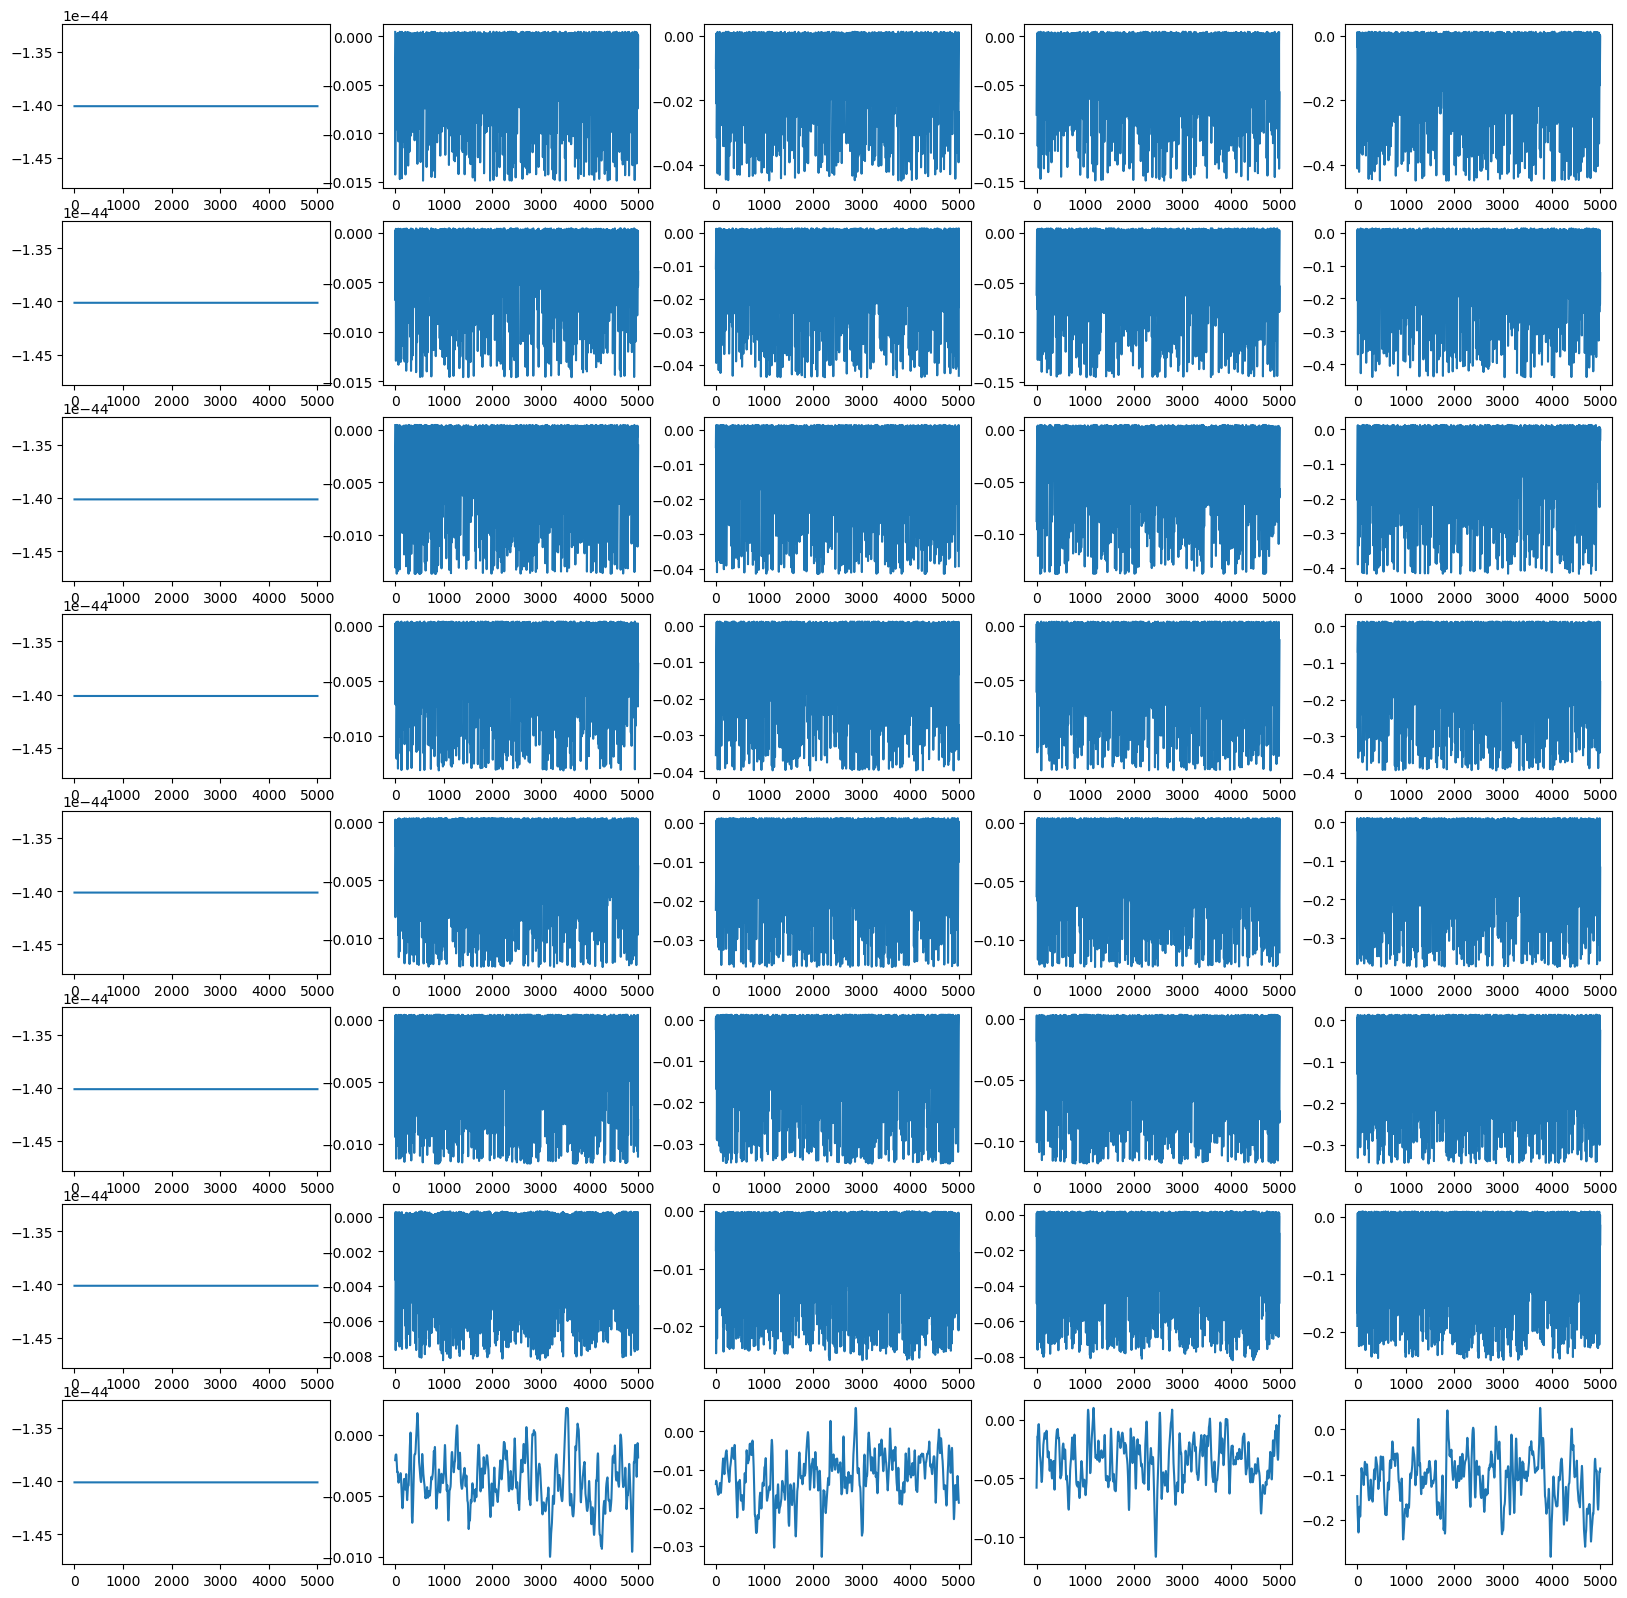

In [93]:
fig, ax = plt.subplots(8, 5, figsize=(20, 20))
for i in range(8):
    for j in range(5):
        ax[i,j].plot(results[1][i,j,0,0])

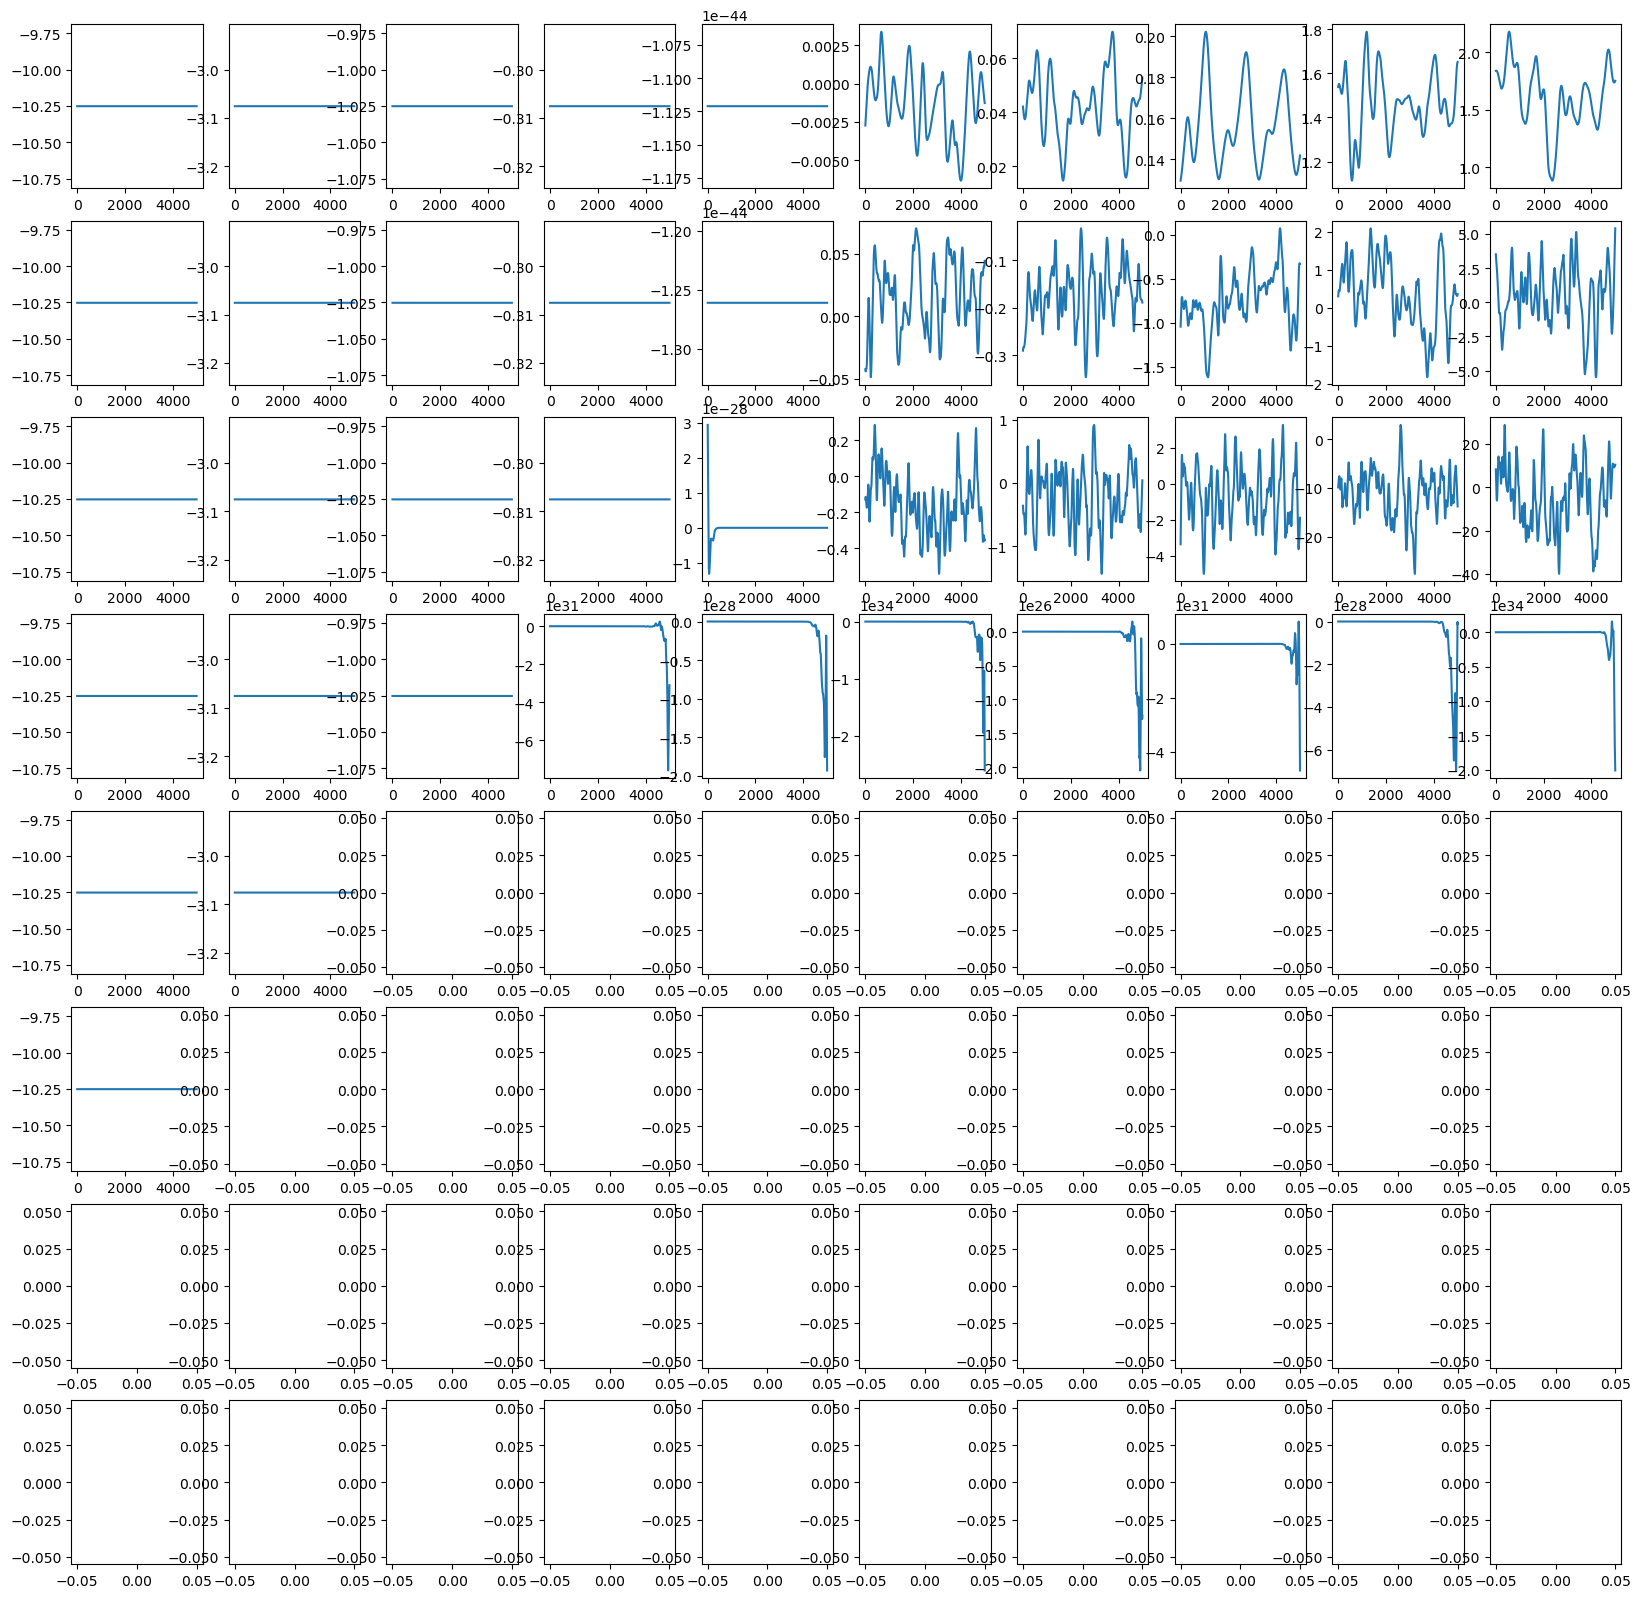

In [80]:
fig, ax = plt.subplots(8, 10, figsize=(20, 20))
for i in range(8):
    for j in range(10):
        ax[i,j].plot(results[1][i,j,2,0])

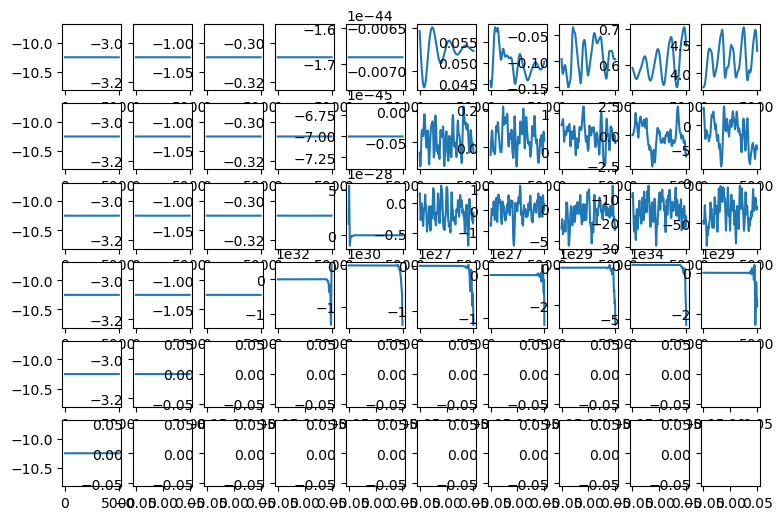

In [67]:
fig, ax = plt.subplots(6, 10, figsize=(9, 6))
for i in range(6):
    for j in range(10):
        ax[i,j].plot(results[1][i,j,0,0])

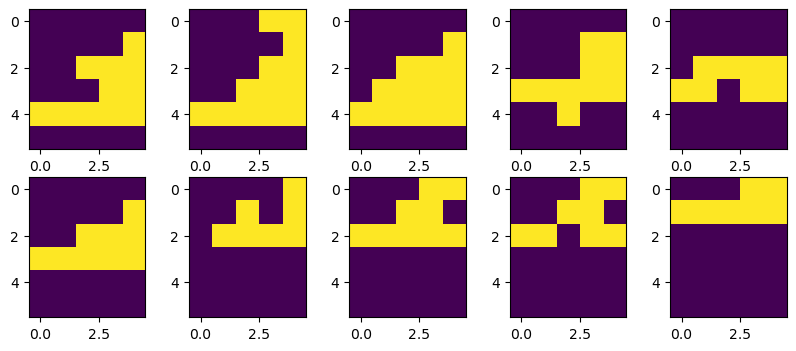

In [106]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
ax = ax.flatten()
for i in range(10):
    #ax[i].imshow(np.isnan(results[1]).any(-1)[:,:,i,0])
    ax[i].imshow(np.abs(results[1]>1).any(-1)[:,:,i,0])